In [2]:
import sys
sys.path.append('..')
import os
import numpy as np
import torch
import torch.nn.functional as F
from base import BaseModel, sample_random, sample_uniform, sample_boundary2D_separate
from base import Random_Basis_Function,Random_Basis_Function_L
from vortex.visualize import draw_vector_field2D, draw_scalar_field2D, draw_curl, draw_magnitude, save_numpy_img, save_figure
from base import gradient, divergence, laplace, jacobian
# from torchsparsegradutils import sparse_triangular_solve, sparse_generic_solve
# from torchsparsegradutils.utils import linear_cg, minres, rand_sparse, rand_sparse_tri
from vortex.sparse_solver import sparse_solve
from scipy import sparse
from vortex.model import Vortex_L

from matplotlib import pyplot as plt

PyTorch version: 2.0.1+cu118
Default GPU is NVIDIA GeForce RTX 3090
Running on cuda
CuPy version: 12.1.0
Running on  <CUDA Device 0>


In [3]:
import os
import argparse
from vortex import Vortex_L


# create experiment config containing all hyperparameters
cfg = argparse.ArgumentParser(add_help=False)

cfg.rho = 1
cfg.internal_v = 8
cfg.variable_list = [2,3]
cfg.time_num = 2
cfg.colloation_pts_num  = 10000
cfg.boundary_num = 6000
cfg.output_path = './results' 
cfg.gravity = 0
cfg.num_per_point_feature = 8
cfg.time_length = 0.2
cfg.num_spatial_basis = 500
cfg.variable_num = 3
cfg.dim = 2
cfg.device = 'cuda'
cfg.band_width = 0.4
cfg.log_dir = './log'
cfg.n_timesteps = 100000
cfg.neighbor_K  = 8
cfg.vis_resolution = 100
cfg.seed = 3242342
model = Vortex_L(cfg)

484


In [4]:
# print(model.spatial_A.shape,model.basis_point.shape)

# fig, ax = plt.subplots(figsize=(5, 5))
# #ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
# ax.scatter(model.basis_point[:,0].detach().cpu().numpy(), model.basis_point[:,1].detach().cpu().numpy())
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# fig.tight_layout()

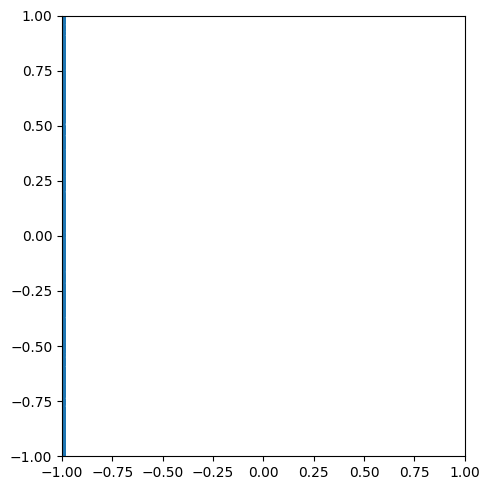

In [5]:
# print(model.time_A.shape)
# print(model.bias.shape)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
ax.scatter(model.total_samples[model.u_left,0].detach().cpu().numpy(), model.total_samples[model.u_left,1].detach().cpu().numpy(),s=10)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.tight_layout()

torch.Size([32000, 8, 2]) torch.Size([32000, 2])
torch.Size([32000, 8, 2])
(8, 3)
tensor([[-0.0846, -0.0461],
        [-0.0846, -0.0461],
        [ 0.1427, -0.0461],
        [ 0.1427, -0.0461],
        [-0.0846, -0.2733],
        [-0.0846, -0.2733],
        [ 0.1427, -0.2733],
        [ 0.1427, -0.2733]], device='cuda:0', grad_fn=<SelectBackward0>)


/tmp/ipykernel_31275/3643758980.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(model.total_samples[432,0].detach().cpu().numpy(), model.total_samples[432,1].detach().cpu().numpy(),c=np.array([1,0,0]))


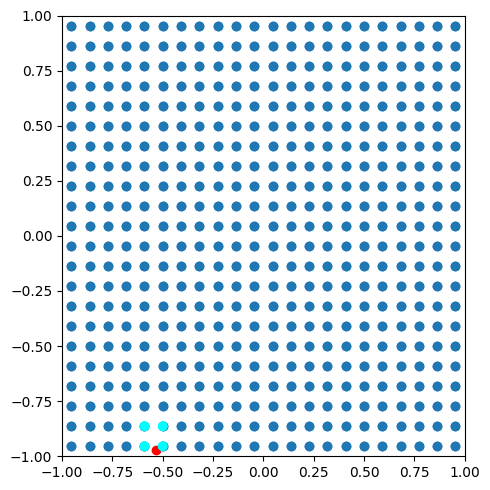

In [6]:
x_,idx = model.neighbor_search_spatial(model.total_samples)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
print(x_.shape)
ct = np.repeat(np.array([[0,1,1]]),x_.shape[1],axis=0)
print(ct.shape)
#A_ = x_.reshape(-1,2)
#ct = np.repeat(np.array([[0,0,1]]),A_.shape[0],axis=0)
ax.scatter(model.total_samples[432,0].detach().cpu().numpy(), model.total_samples[432,1].detach().cpu().numpy(),c=np.array([1,0,0]))
ax.scatter(model.basis_point[:,0].detach().cpu().numpy(), model.basis_point[:,1].detach().cpu().numpy())
ax.scatter(model.basis_point[idx[432],0].detach().cpu().numpy(), model.basis_point[idx[432],1].detach().cpu().numpy(),c=ct)
print(x_[432])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.tight_layout()


In [9]:
total_ = model.num_time_feature*model.num_spatial_basis
h = idx.shape[1]
bz = idx.shape[0]
# Size is a problem here, we might abondon time
A_process = model.spatial_A.reshape(total_,-1)
A_process = A_process.unsqueeze(0).expand(bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,A_process.shape[-1]) 
A_process = torch.gather(A_process,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature,model.dim)
#t_process_ = model.time_A.reshape(total_,-1)
#t_process_ = t_process_.unsqueeze(0).expand(bz,-1,-1)
#idx_ = idx.unsqueeze(-1).expand(-1,-1,t_process_.shape[-1])
#t_process_ = torch.gather(t_process_,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature)
bias_process = model.bias.reshape(total_,-1)
bias_process = bias_process.unsqueeze(0).expand(bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,bias_process.shape[-1])
bias_process = torch.gather(bias_process,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature)
        
sptail_val = torch.einsum('qhejd,qhd->qhej',A_process,x_)
#time_val = torch.einsum('qhej,qh->qhej',t_process_,t_)
ot = model.non_linear(sptail_val+bias_process)
# print(A_process[432,0],x_[432,0])
# print(idx[432])
# print(model.spatial_A.reshape(total_,-1)[248])
# print(sptail_val[432,0])

x_weight = model.PoU(x_)
delta_t = 0.01


q_,h_,e_,j_ = ot.shape
ot = ot.reshape(ot.shape[0],-1)

L1,_ = jacobian(ot, model.total_samples)
L1 = L1.reshape(q_,h_,e_,j_,-1)
# print(L1[432,0])
L2 = None
# Lt,_ = jacobian(ot,model.t)
# Lt = Lt.reshape(q_,h_,e_,j_,-1)
ot = ot.reshape(q_,h_,e_,j_ )

In [10]:
j = model.num_per_point_feature
num = 0
h_use = idx.shape[1]
bz_use = idx.shape[0]
total_use = model.num_time_feature*model.num_spatial_basis
idx_box = model.idx_box.reshape(total_use,-1)
idx_box = idx_box.unsqueeze(0).expand(bz_use,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,idx_box.shape[-1])
idx_box = torch.gather(idx_box,1,idx_).reshape(-1,h_use,model.variable_num,model.num_per_point_feature)

# Here, we first consider 2D advection.

In [ ]:

part_1 = model.rho * torch.einsum('qhejd,qhej->qhdj', L1[model.inner_pts,...,:model.variable_list[0],:,:], ot[model.inner_pts,...,:model.variable_list[0],:])
part_1 = model.rho * Lt[model.inner_pts,...,:model.variable_list[0],:,:].reshape_as(part_1) + part_1
part_2 = L1[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:,:].permute(0,1,2,4,3).reshape_as(part_1)

RHS_1 = torch.ones_like(ot[model.inner_pts,0,:model.variable_list[0],0]) * model.cfg.gravity * model.rho
# LHS: (qe)hj
part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
part_2 = part_2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
print(part_1.shape,part_2.shape)
LHS_1 = torch.cat([part_1,part_2],dim=1)

RHS_1 = RHS_1.reshape(model.inner_pts.shape[0]*model.variable_list[0])
#idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
idx1_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
idx1_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
idx1_part1 = idx1_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
idx1_part2 = idx1_part2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
idx1 = torch.cat([idx1_part1,idx1_part2],dim=1)
print(LHS_1.shape,idx1.shape)
dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)


num = 0
# LHS2: qhej
LHS_2 = torch.einsum('qhdjd->qhdj',L1[model.inner_pts,...,:model.variable_list[0],:,:])
RHS_2 = torch.zeros_like(ot[model.inner_pts,0,:model.variable_list[0],0])
LHS_2 = LHS_2.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
#idx2 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
idx2 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
idx2 = idx2.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

dimk = torch.linspace(num,num+LHS_2.shape[0]-1,LHS_2.shape[0]).to(model.device).unsqueeze(1).repeat(1,LHS_2.shape[1])
idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)

num = 0
# LHS3: q'hej (Some problem!!!)
LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[model.neu_bound,:,:model.variable_list[0]], model.norm)
RHS_3 = torch.zeros_like(ot[model.neu_bound,0,0,0])
LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
#idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)


# LHS4: q'hej
num = 0
LHS_4 = ot[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
RHS_4 = torch.zeros_like(ot[model.dir_bound,0,0,0])
LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
#idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)

num = 0
# LHS5: q'hej
LHS_5 = ot[model.u_left,...,:model.variable_list[0],:]

RHS_5 = torch.zeros_like(ot[model.u_left,0,:model.variable_list[0],0])
RHS_5[...,1] = 0
RHS_5[...,0] = model.internal_v
LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
#print(RHS_5)
RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
# idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)
num = 0

# LHS6: q'hej
LHS_6 = ot[model.init_pts]
RHS_6 = torch.zeros_like(ot[model.init_pts,0,:,0])
LHS_6 = LHS_6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
RHS_6 = RHS_6.reshape(model.init_pts.shape[0]*model.variable_list[1])
#idx6 = model.expand_idx(idx[model.init_pts],0,model.variable_list[1]) #(qe)hj
idx6 = idx_box[model.init_pts]
idx6 = idx6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
dimk = torch.linspace(num,num+LHS_6.shape[0]-1,LHS_6.shape[0]).unsqueeze(-1).repeat(1,LHS_6.shape[1]).to(model.device)
idx6 = torch.stack([idx6,dimk],dim=2).reshape(-1,2)


torch.Size([10000, 128]) torch.Size([10000, 128])
torch.Size([10000, 256]) torch.Size([10000, 192])


# Linear PDE solver

In [ ]:
LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5,LHS_6]
RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5,RHS_6]
idx_tp = [idx1,idx2,idx3,idx4,idx5,idx6]

LHS = []
RHS = []
idx = []
num = 0
for i,LHS_ in enumerate(LHS_tp):
    max_x = torch.abs(LHS_).max()
    if max_x>0.0:
        LHS.append(LHS_/max_x)
        RHS.append(RHS_tp[i]/max_x)
        idx_tp[i][:,1] = idx_tp[i][:,1] + num
        idx.append(idx_tp[i])
        print(LHS_.shape[0]*LHS_.shape[1],idx_tp[i].shape[0])
        num += LHS_.shape[0] 
#LHS: q?h?ej
q = sum([i.shape[0] for i in LHS])
h = model.num_time_feature*model.num_spatial_basis*model.variable_num*model.num_per_point_feature

LHS = torch.cat([i.reshape(-1) for i in LHS],dim=0)
idx = torch.cat(idx,dim=0).long()
# mask = (LHS==0)
# LHS = LHS[~mask]
# idx = idx[~mask]

print(LHS.shape,idx.shape)
print(h)
idx = torch.stack([idx[:,1],idx[:,0]],dim=1)

# cuda cupy ver
#A = torch.sparse_coo_tensor(idx.transpose(0,1),LHS,[q,h])
#b = torch.cat(RHS,dim=0)
LHS_s = LHS
idx_s = idx
# numpy ver
LHS = LHS.double().detach().cpu().numpy()
idx = idx.detach().cpu().numpy()
A = sparse.coo_matrix((LHS,(idx[:,0],idx[:,1])),shape=(q,h)).tocsr()
b = torch.cat(RHS,dim=0).unsqueeze(1).double().detach().cpu().numpy()
print(b.shape)


utz = A.shape[1]
idxu = (A.getnnz(0)>0)
A = A[:,A.getnnz(0)>0]
out = sparse.linalg.lsqr(A,b)
b_ = b
#print(out[1:5])

a,b,c,d = model.u_.shape
u = out[0]
# print(np.sum(np.abs(u)))
ut = np.zeros(utz)
ut[idxu] = u
ut = torch.from_numpy(ut).to(model.device)

model.u_ = model.u_.reshape(-1)
model.u_ = ut
model.u_ = model.u_.reshape(a,b,c,d)

# A_ = torch.sparse_coo_tensor(idx_s.transpose(0,1),LHS_s,(q,h))
# print(A_@model.u_.reshape(-1).float())

# print(model.u_)

# velos, samples = model.sample_field(model.vis_resolution,model.vis_resolution//20, return_samples=True)

grid_samples = sample_uniform(model.vis_resolution, 2, device=model.device, flatten=True).requires_grad_(True)
boundary_samples,norm = model.process_boundary(model.vis_resolution//20)
total_samples = torch.cat([grid_samples,boundary_samples],dim=0)
total_samples,t,norm = model.process_time(model.time_num,model.time_length,total_samples,norm)

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(total_samples[:,0].detach().cpu().numpy(), total_samples[:,1].detach().cpu().numpy())

# print(total_samples)
#print(model.basis_point.shape)
out = model.inference(model.total_samples[model.u_left].reshape(-1,2),model.t[model.u_left].reshape(-1,1))
velos, samples = out,model.total_samples[model.u_left]
velos = velos.detach().cpu().numpy()
#print(velos)
samples = samples.detach().cpu().numpy()
velos = velos.reshape(model.time_num,-1,model.variable_list[1])
samples = samples.reshape(model.time_num,-1,2)
#print(velos.shape,samples.shape)
print(np.max(velos[0,:,:model.variable_list[0]].reshape(-1,2),axis=0))
fig = draw_vector_field2D(velos[0,:,:model.variable_list[0]], samples[0,:,:])


2560000 1920000
1280000 1280000
384000 384000
96000 96000
384000 384000
2784000 2784000
torch.Size([7488000]) torch.Size([6848000, 2])
23232


ValueError: row, column, and data array must all be the same length